In [39]:
import torch
import json
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [366]:
dictionary = json.loads(open("dictionary_compact.json", "r").read())
len(dictionary)

102217

In [367]:
dictionary_split = {}
for word, definitions in dictionary.items():
    definitions = definitions.replace("1.", ";").replace("2.", ";").replace("3.", ";").replace("4.", ";").replace("5.", ";").replace("6.", ";").replace("7.", ";").split(";")

    definitions_fixed = []

    for definition in definitions:
        # remove trailing and starting spaces
        definition = definition.strip()
        # remove special characters
        definition = definition.replace(".", "").replace(",", "").replace("'", "").replace("\"", "").replace("\n", "").replace("(", "").replace(")", "").replace("]", "").replace("[", "")
        if len(definition) < 1:
            continue
        if definition[0].lower() == "see":
            word_to_see = " ".join(definition[1:])
            definition = dictionary.get(word_to_see.lower(), word_to_see) # get the word's definition, if it doesn't exist just use that word

        definitions_fixed.append(definition)  

    dictionary_split[word] = definitions_fixed

dictionary_split

{'anopheles': ['A genus of mosquitoes which are secondary hosts of the malaria parasites and whose bite is the usual if not the only means of infecting human beings with malaria Several species are found in the United States They may be distinguished from the ordinary mosquitoes of the genus Culex by the long slender palpi nearly equaling the beak in length while those of the female Culex are very short They also assume different positions when resting Culex usually holding the body parallel to the surface on which it rests and keeping the head and beak bent at an angle while Anopheles holds the body at an angle with the surface and the head and beak in line with it Unless they become themselves infected by previously biting a subject affected with malaria the insects cannot transmit the disease'],
 'uniclinal': ['See Nonoclinal'],
 'sarong': ['A sort of petticoat worn by both sexes in Java and the Malay Archipelago Balfour Cyc of India'],
 'turcoman': ['A member of a tribe of Turanian

In [368]:
print(json.dumps(dict(list(dictionary_split.items())[:5]), indent=4))

{
    "anopheles": [
        "A genus of mosquitoes which are secondary hosts of the malaria parasites and whose bite is the usual if not the only means of infecting human beings with malaria Several species are found in the United States They may be distinguished from the ordinary mosquitoes of the genus Culex by the long slender palpi nearly equaling the beak in length while those of the female Culex are very short They also assume different positions when resting Culex usually holding the body parallel to the surface on which it rests and keeping the head and beak bent at an angle while Anopheles holds the body at an angle with the surface and the head and beak in line with it Unless they become themselves infected by previously biting a subject affected with malaria the insects cannot transmit the disease"
    ],
    "uniclinal": [
        "See Nonoclinal"
    ],
    "sarong": [
        "A sort of petticoat worn by both sexes in Java and the Malay Archipelago Balfour Cyc of India"


In [369]:
dictionary_reversed = {}

for word, definitions in dictionary_split.items():
    if word == " ": continue
    for definition in definitions:
        if definition == " ": continue
        dictionary_reversed[definition] = word
len(dictionary_reversed)

283817

In [370]:
words = []

for definition, term in dictionary_reversed.items():
    words.append(term)
    for word in definition.split(" "):
        words.append(word)

words = list(set(words))

In [371]:
wtoi = {word: index+1 for index, word in enumerate(words)}
itow = {index: word for word, index in wtoi.items()}
itow[0] = "<e>"

In [372]:

context_length = 900
X, Y = [], []
for definition, term in dictionary_reversed.items():
    index = wtoi[term]
    context = [wtoi[word] for word in definition.split(" ")]
    context += [0] * (context_length - len(context))

    X.append(context)
    Y.append(index)

X = torch.tensor(X)
Y = torch.tensor(Y)


In [373]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([283817, 900]), torch.int64, torch.Size([283817]), torch.int64)

In [374]:
del dictionary
del dictionary_split
del words

In [375]:
# embeddings space
# C = torch.randn(len(dictionary_reversed.keys()), 2) # for testing
C = torch.randn(len(dictionary_reversed.keys()), 10) # <-- gets pretty ok loss (12) (but best here)

In [376]:
# layer 1
W1 = torch.randn(C.shape[1]*X.shape[1], 100)
b1 = torch.randn(100)

# layer 2
W2 = torch.randn(100, len(Y))
b2 = torch.randn(len(Y))


In [377]:
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad=True

In [378]:
sum([p.nelement() for p in parameters])

32403787

In [379]:
loss_step = []
steps_i = []

In [380]:
lr_exp = torch.linspace(-20, -1, 200)
lrs = 10**lr_exp

In [381]:
lr_0 = 0.01

for k in range(300):
    # minibatch indexes
    indexes = torch.randint(0, X.shape[0], (100,))

    embeddings = C[X[indexes]]

    hidden1 = torch.relu(embeddings.view(-1, embeddings.shape[1]*embeddings.shape[2]) @ W1 + b1)
    logits = hidden1 @ W2 + b2
    loss = F.cross_entropy(logits, Y[indexes])

    lr = lr_0 if k < 15 else lr_0 * (1/(1+0.8*k))
    for p in parameters: # zero grad
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad
    steps_i.append(k)
    loss_step.append(loss.data)
    print(f"{k}: {loss.data}")

0: 2584.523193359375
1: 6869.244140625
2: 8788.7822265625
3: 7540.861328125
4: 10222.6220703125
5: 10525.244140625
6: 15304.712890625
7: 12213.96875
8: 21886.6171875
9: 13198.240234375
10: 4215.42431640625
11: 784.284912109375
12: 124.93069458007812
13: 284.2906188964844
14: 15.535335540771484
15: 21.202346801757812
16: 13.42092514038086
17: 13.133572578430176
18: 13.099957466125488
19: 13.17529582977295
20: 13.048503875732422
21: 13.05738639831543
22: 13.014577865600586
23: 13.430068016052246
24: 12.90587043762207
25: 13.077733039855957
26: 13.172433853149414
27: 13.058995246887207
28: 14.015068054199219
29: 12.963709831237793
30: 15.164953231811523
31: 13.167247772216797
32: 20.891660690307617
33: 13.067743301391602
34: 13.073219299316406
35: 13.206932067871094
36: 13.018842697143555
37: 13.028820037841797
38: 13.971617698669434
39: 12.895914077758789
40: 16.676454544067383
41: 12.998193740844727
42: 13.203030586242676
43: 13.001476287841797
44: 12.9951810836792
45: 13.02289295196533

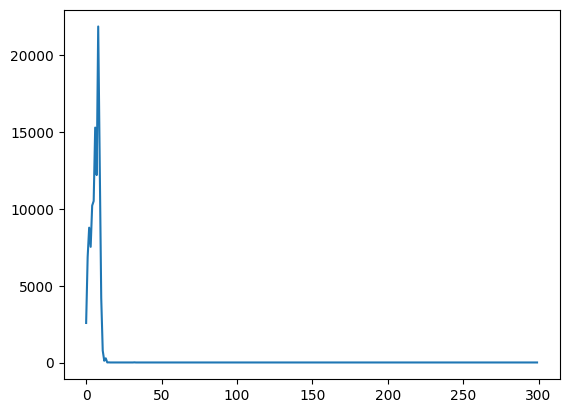

In [382]:
# loss with 2 layers
plt.plot(steps_i, loss_step)

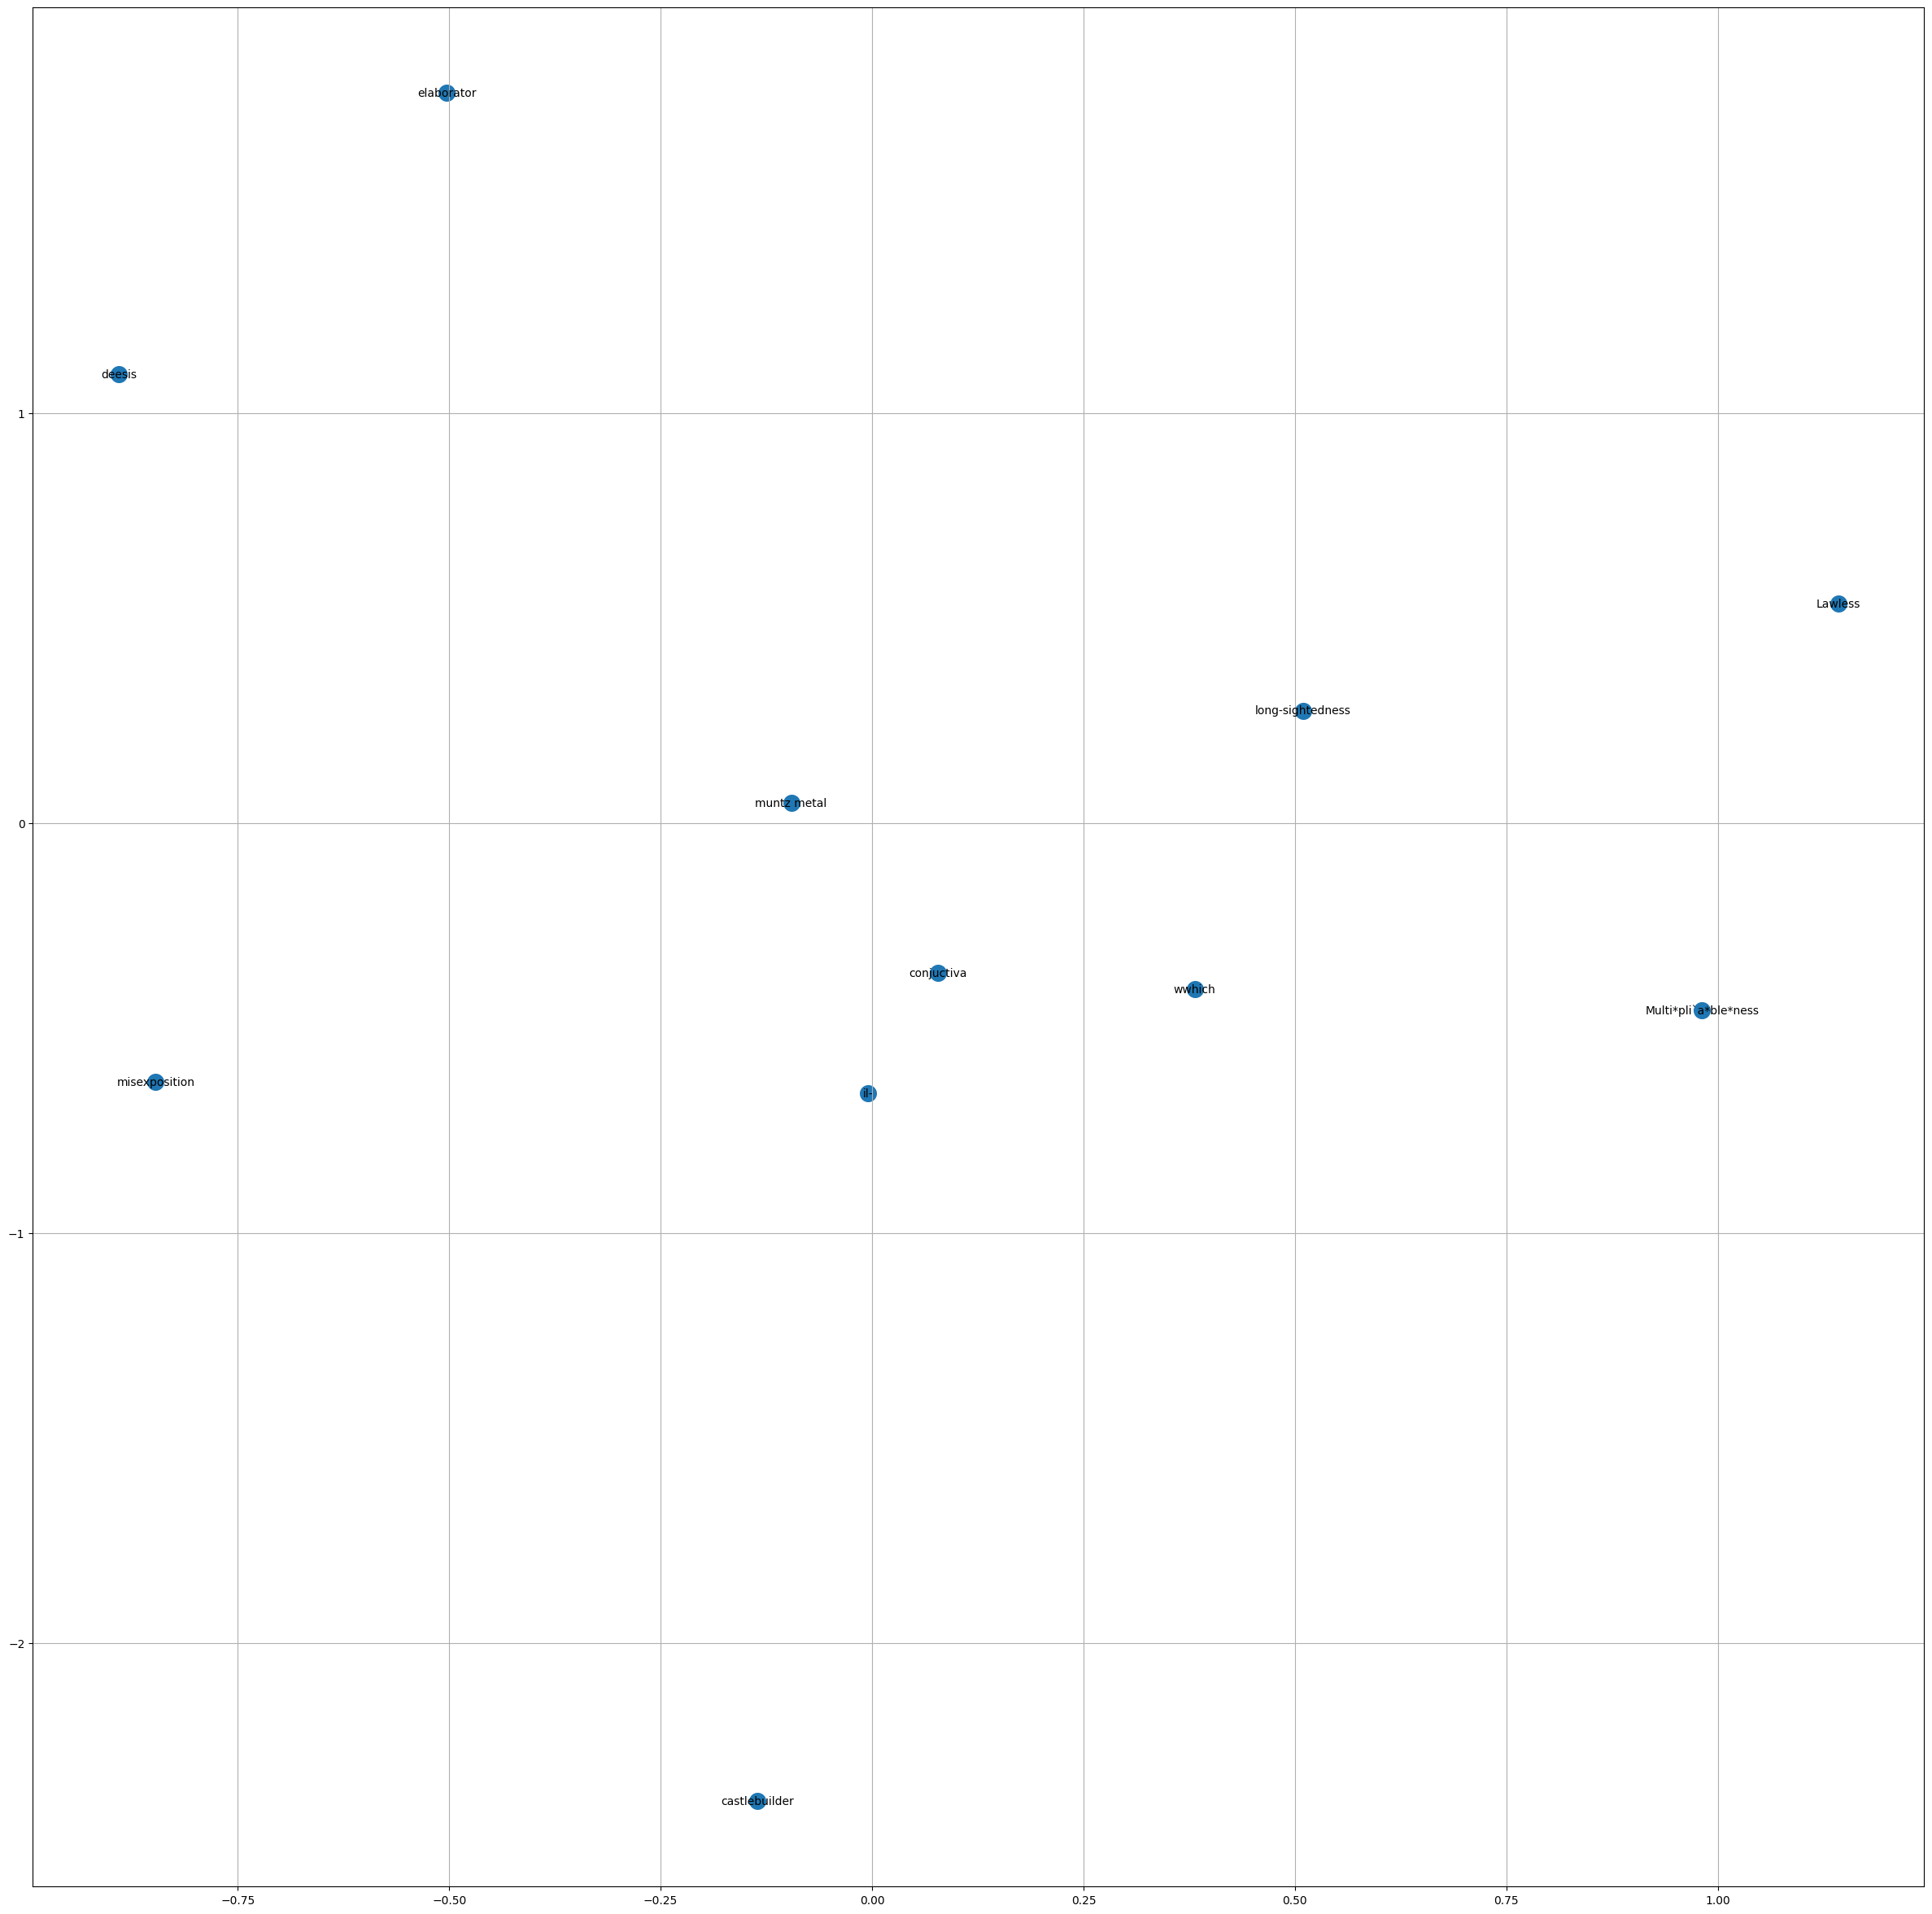

In [383]:
indexes = torch.cat((torch.randint(0, len(wtoi), (10,)), torch.tensor([190291])))
plt.figure(figsize=(30, 30))
plt.scatter(C[indexes, 0].data, C[indexes, 1].data, s=200)
for i in indexes:
    plt.text(C[i, 0].item(), C[i, 1].item(), itow[int(i)], ha="center", va="center", color="black")
plt.grid("minor")

In [389]:
g = torch.Generator().manual_seed(2147483647)

context = input("enter text: ").replace(".", "").replace(",", "").replace("'", "").replace("\"", "").replace("\n", "").replace("(", "").replace(")", "").split(" ")
context = [wtoi[word] for word in context] + [0] * (context_length - len(context))
emb = C[torch.tensor(context)] # (1,block_size,d)
h = torch.relu(emb.view(1, -1) @ W1 + b1)
logits = h @ W2 + b2
probs = F.softmax(logits, dim=1)
ix = torch.multinomial(probs, num_samples=1, generator=g)
list(wtoi.keys())[ix]
# completely overfitted

'micrographic'

In [385]:
probs.sort(1)

torch.return_types.sort(
values=tensor([[1.6833e-08, 1.8498e-08, 2.4871e-08,  ..., 1.5506e-04, 1.6462e-04,
         1.7140e-04]], grad_fn=<SortBackward0>),
indices=tensor([[160195, 125162,  61134,  ..., 127967,  15001, 158368]]))